In [35]:
import numpy as np
import MITgcmutils
import matplotlib.pyplot as plt
from utils.resample_to_latlon import resample_to_latlon
from utils.utils import conversion, plot_pcolor
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
import os
import sys

path_grid = "ECCO2/LLC270/ECCO-Darwin_extension/grid"
path_3d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d"
path_2d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d"

#### Variable list

In [2]:
fldList_3d = ['TRAC01','ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01',
              'DFrITr01','gDAR01','cDIC','cDIC_PIC','respDIC','rDIC_DOC','rDIC_POC','dDIC_PIC']
fldList_2d = ['ETAN','oceFWflx','SFLUX','TFLUX','oceSPflx','oceQsw','fluxCO2','gDICsurf',
           'gDICEpr','gALKEpr','gNO3Epr','gNO2Epr','gNH4Epr','gO2Epr','gPO4Epr','gFeTEpr','gSiO2Epr']

mapping_3d = list(zip(range(len(fldList_3d)),fldList_3d))
mapping_2d = list(zip(range(len(fldList_2d)),fldList_2d))

variable_selection_2d = [6,8]
variable_selection_3d = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14]


display(mapping_3d)
print()
display(mapping_2d)

variable_names = [mapping_3d[idx][1] for idx in variable_selection_3d] + [mapping_2d[idx][1] for idx in variable_selection_2d]

[(0, 'TRAC01'),
 (1, 'ADVxTr01'),
 (2, 'ADVyTr01'),
 (3, 'ADVrTr01'),
 (4, 'DFxETr01'),
 (5, 'DFyETr01'),
 (6, 'DFrETr01'),
 (7, 'DFrITr01'),
 (8, 'gDAR01'),
 (9, 'cDIC'),
 (10, 'cDIC_PIC'),
 (11, 'respDIC'),
 (12, 'rDIC_DOC'),
 (13, 'rDIC_POC'),
 (14, 'dDIC_PIC')]

[(0, 'ETAN'),
 (1, 'oceFWflx'),
 (2, 'SFLUX'),
 (3, 'TFLUX'),
 (4, 'oceSPflx'),
 (5, 'oceQsw'),
 (6, 'fluxCO2'),
 (7, 'gDICsurf'),
 (8, 'gDICEpr'),
 (9, 'gALKEpr'),
 (10, 'gNO3Epr'),
 (11, 'gNO2Epr'),
 (12, 'gNH4Epr'),
 (13, 'gO2Epr'),
 (14, 'gPO4Epr'),
 (15, 'gFeTEpr'),
 (16, 'gSiO2Epr')]

#### importing data

In [3]:
d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.0000002232",rec=variable_selection_2d)
d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.0000002232",rec=variable_selection_3d)

# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]

#### Conversion

In [4]:
# convert 3D variables
for var_idx in range(13):
    d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)

# convert 2D variables
for var_idx in range(2):
    d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    

#### Flatten 3d data

In [5]:
# getting index of top 100m depth
idx_top_100m = np.where(depth_c>=-100)[0]

# Using numpy
delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m

#### Combine and process variables

In [6]:
# combine data
combined_data = np.concatenate((flattened_d3, d_2), axis=0)

# create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
mask = combined_data[0]==0
combined_data[:,mask] = np.nan

# Interpolating the curvilinear line to the cartesian plane
new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
new_grid_min_lat, new_grid_max_lat = -90, 90
new_grid_min_lon, new_grid_max_lon = -180, 180
new_shape = (combined_data.shape[0],
             int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
             int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))

variables_cart = np.empty(new_shape)

for variable in range(combined_data.shape[0]):  
    lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                resample_to_latlon(lon,lat,combined_data[variable],
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.NaN,
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
                                                                         
variables_cart.shape

(15, 360, 720)

#### Integrating accross timestep

In [8]:
# Getting the timestep values
timestep_list = [path.split(".")[1] for path in glob(f"{path_3d}/*.meta")]
timestep_list.sort()

#importing metas
# meta_list = [MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d,returnmeta=True)[2] 
#              for timestep in timestep_list]

# timestep_num_list = [int(meta["timestepnumber"][0]) for meta in meta_list]
timestep_num_list = [int(item) for item in timestep_list]

timestep_delta = np.diff(np.array(timestep_num_list), prepend=timestep_num_list[0])
len(timestep_delta)


378

In [40]:
# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]

timestep_list = [path.split(".")[1] for path in glob(f"{path_2d}/*.data")]
timestep_list.sort()

# Checking to see if variable already exist. wont run the loop if yes==============================================
if os.path.exists("variables_cart_final.npy"):
    print("variables_cart_final.npy already exists. Skipping this cell.")
    variables_cart_final = np.load("variables_cart_final.npy")
# ===================================================================================================================

else:
    # Initialize sum with checkpointing piece ==========================================================================
    checkpoint_list = [int(path.split("_")[4].split(".")[0]) for path in glob(f"checkpoints/*.npy")]
    if len(checkpoint_list) > 0:
        checkpoint_list.sort()
        checkpoint_val = checkpoint_list[-1]
        variables_cart_sum_timesteps = np.load(f"checkpoints/variables_cart_final_checkpoint_{checkpoint_val}.npy")
        print(f"Resuming from checkpoint {checkpoint_val}")
    else:
        checkpoint_val = -1  # No checkpoint exists, start from scratch
        variables_cart_sum_timesteps = np.zeros(shape=variables_cart.shape)
    # ===================================================================================================================
                
    for i,(timestep,delta_val) in enumerate(zip(timestep_list,timestep_delta)):
        # checkpointing piece ==========================================================================
        if i <= checkpoint_val:
            continue
        # ==============================================================================================
        
        # print(f"Started running for time step: {timestep}")
        # import 2d and 3d variables ==========================================================================
        d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d)
        d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.{timestep}",rec=variable_selection_3d)
        # =========================================================================================================
    
        # Conversion ===============================================================================================
        # convert 3D variables into standard units
        for var_idx in range(13):
            d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
        
        # convert 2D variables into standard units
        for var_idx in range(2):
            d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
        # =========================================================================================================
    
        # FLattening ==============================================================================================
        # Flatten 3D variables upto 100m
        idx_top_100m = np.where(depth_c>=-100)[0] # getting index of top 100m depth
        
        # Integrate across Depth=====================================================================================
        delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
        flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m
        # ===========================================================================================================
        
        # Conversion into Cratesian grid ============================================================================
        combined_data = np.concatenate((flattened_d3, d_2), axis=0) # combine data
        
        # create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
        mask = combined_data[0]==0
        combined_data[:,mask] = np.nan
        
        # Interpolating the curvilinear line to the cartesian plane
        new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
        new_grid_min_lat, new_grid_max_lat = -90, 90
        new_grid_min_lon, new_grid_max_lon = -180, 180
        new_shape = (combined_data.shape[0],
                     int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
                     int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))
        
        variables_cart = np.empty(new_shape)
        
        for variable in range(combined_data.shape[0]):  
            lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                        resample_to_latlon(lon,lat,combined_data[variable],
                                        new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                        new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                        fill_value = np.NaN,
                                        mapping_method = 'nearest_neighbor',
                                        radius_of_influence = 120000)
        # =======================================================================================================
        
        variables_cart_sum_timesteps = variables_cart_sum_timesteps + (variables_cart * delta_val)
        
        
        if i%50 == 0:
            print(f"Saving iteration {i}")
            np.save(f"checkpoints/variables_cart_final_checkpoint_{i}.npy", variables_cart_sum_timesteps)
        if i%20==0:
            print(f"finished {i}. Current timestep: {timestep}")
    
    variables_cart_final = variables_cart_sum_timesteps/sum(timestep_delta)
    np.save("variables_cart_final.npy", variables_cart_final)

variables_cart_final.npy already exists. Skipping this cell.


#### plotting

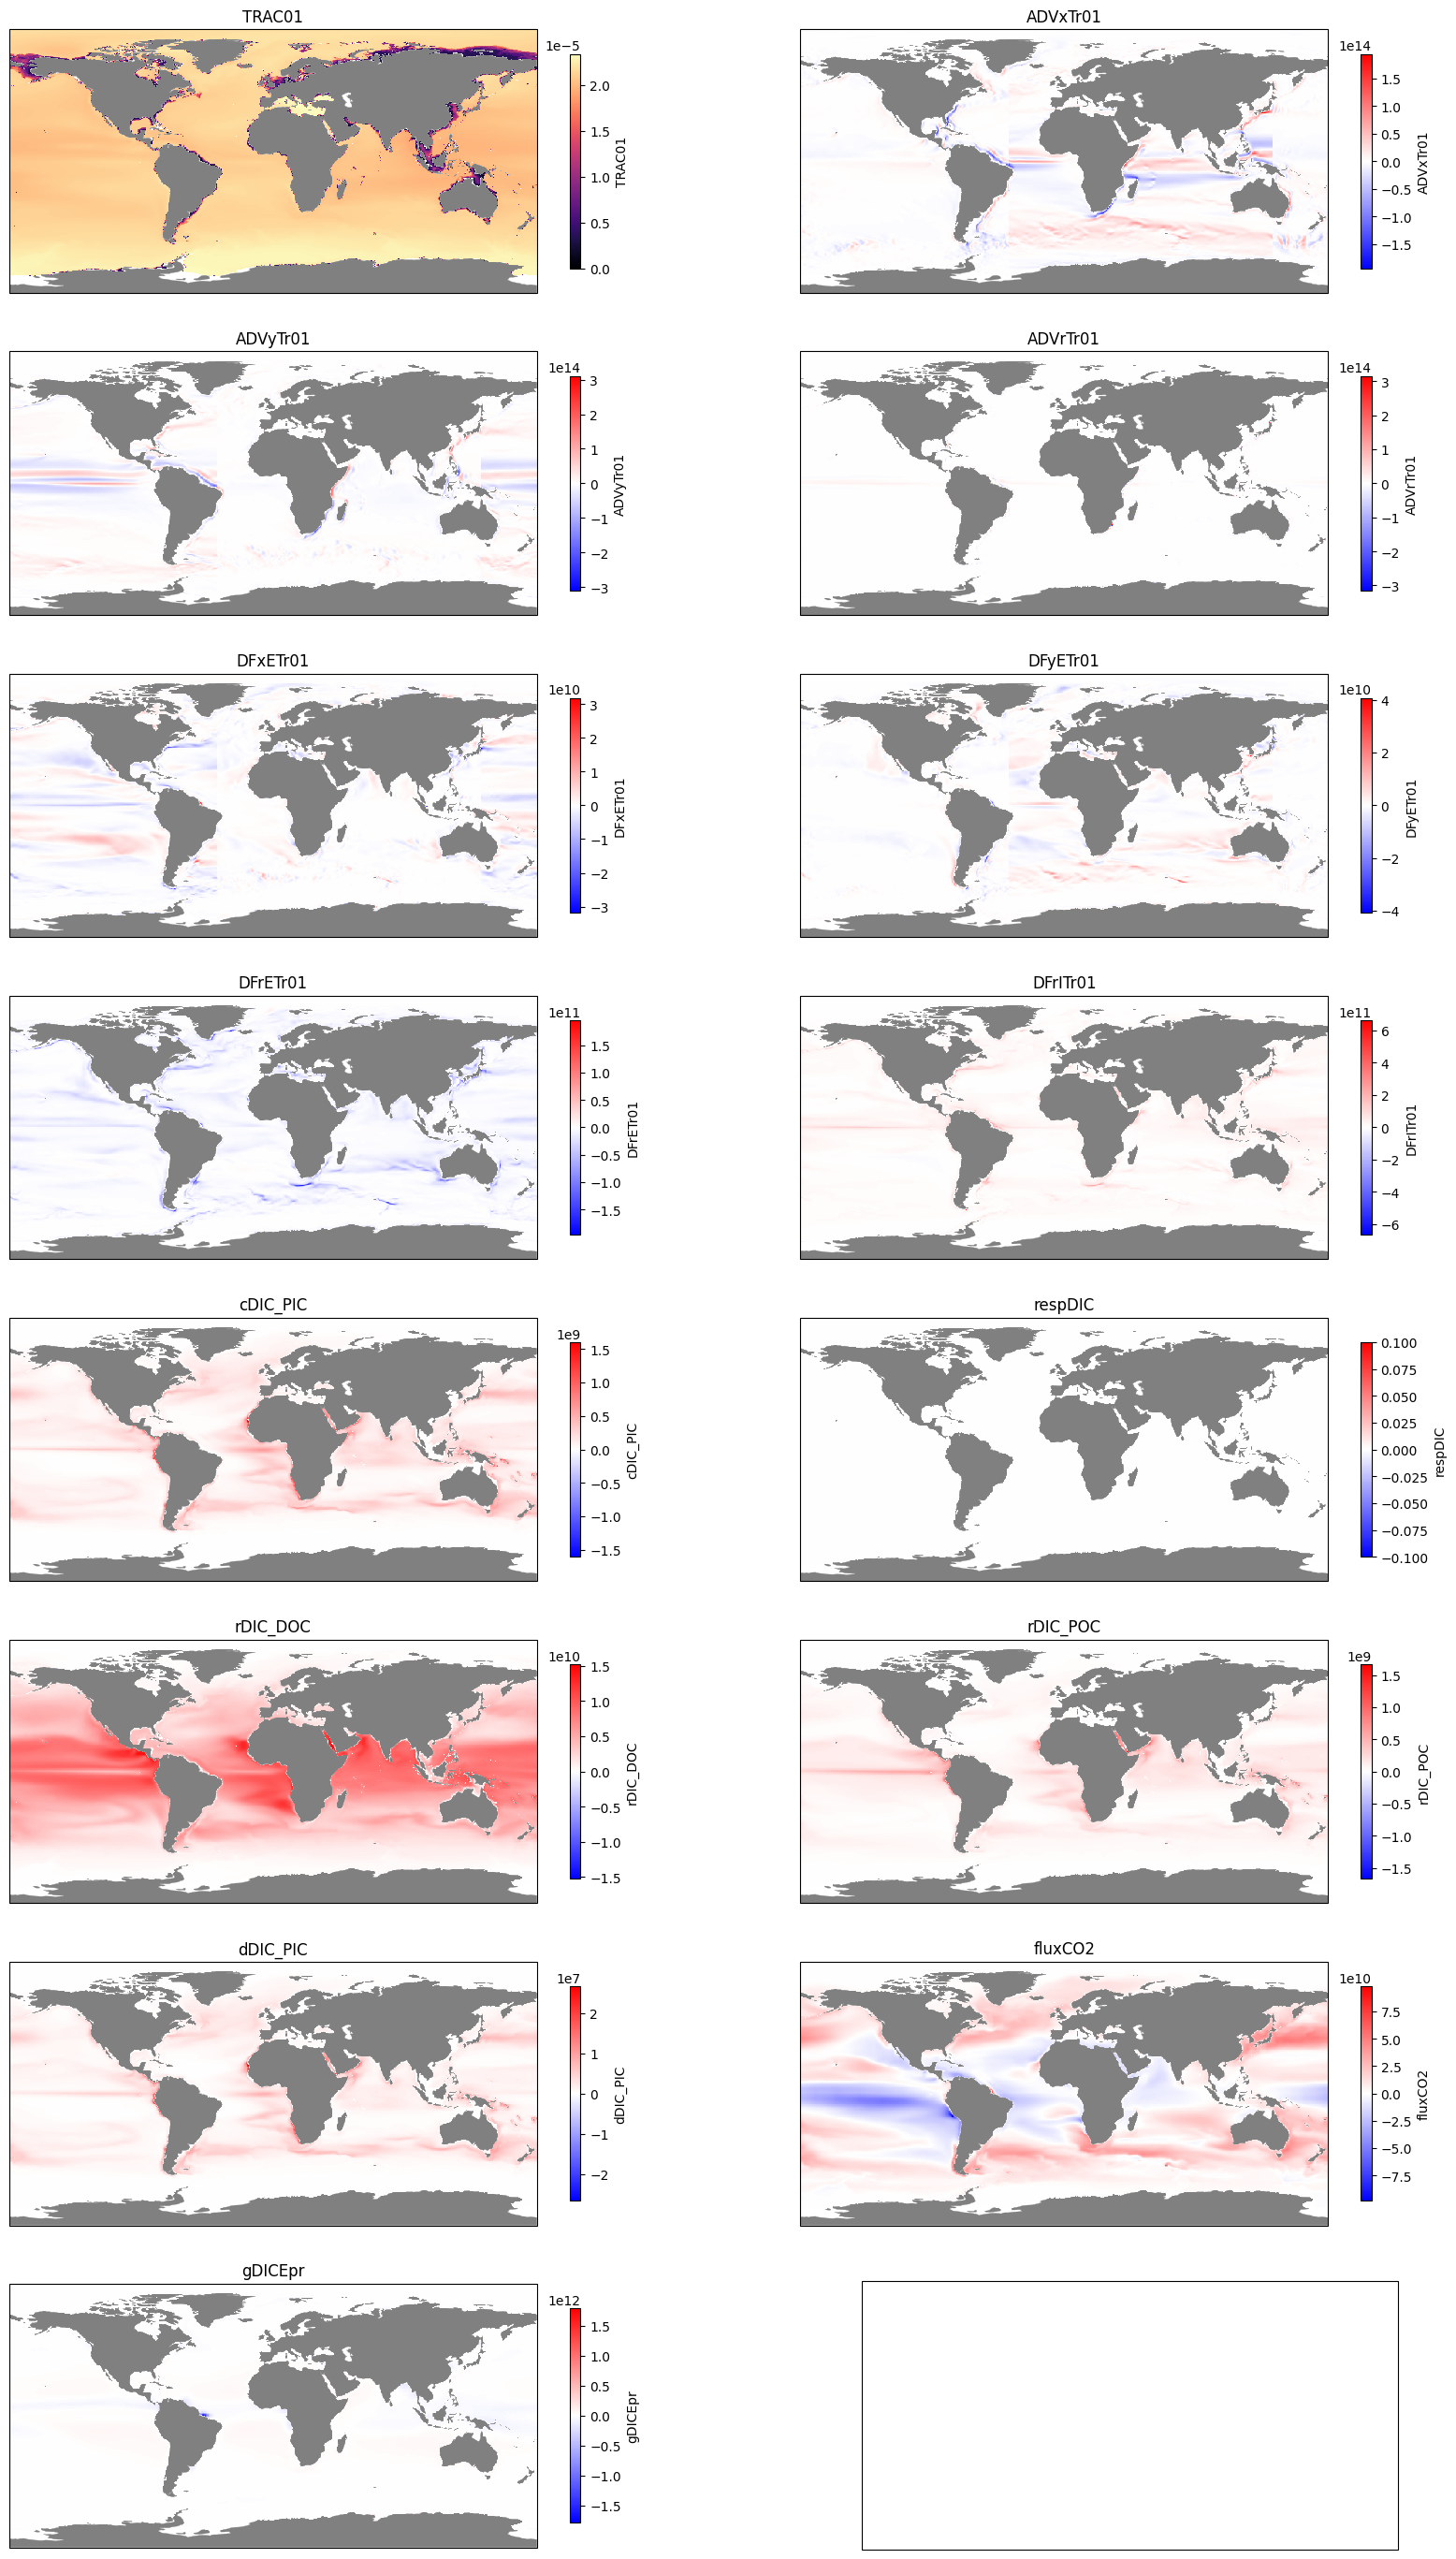

In [43]:
# pcolormesh for time integrated data
fig, axes = plt.subplots(8, 2, figsize=(20, 35), subplot_kw={'projection': ccrs.PlateCarree()})  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# iterate using utils functions
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = variables_cart_final[var_idx]  # Color values for the current variable

    if var_name == "TRAC01": 
        vmax,vmin,cmap  = np.nanmax(variables_cart_final[0]), 0, "magma"
    else:
        vmax,vmin,cmap = None, None, "bwr"
        
    plot_pcolor(ax=ax, values=variables_cart_final[var_idx], lon=lon_cart, lat=lat_cart, var_name=var_name,vmin=vmin, vmax=vmax,cmap=cmap)

plt.savefig("time integrated.png", dpi=300, bbox_inches="tight")
plt.show()

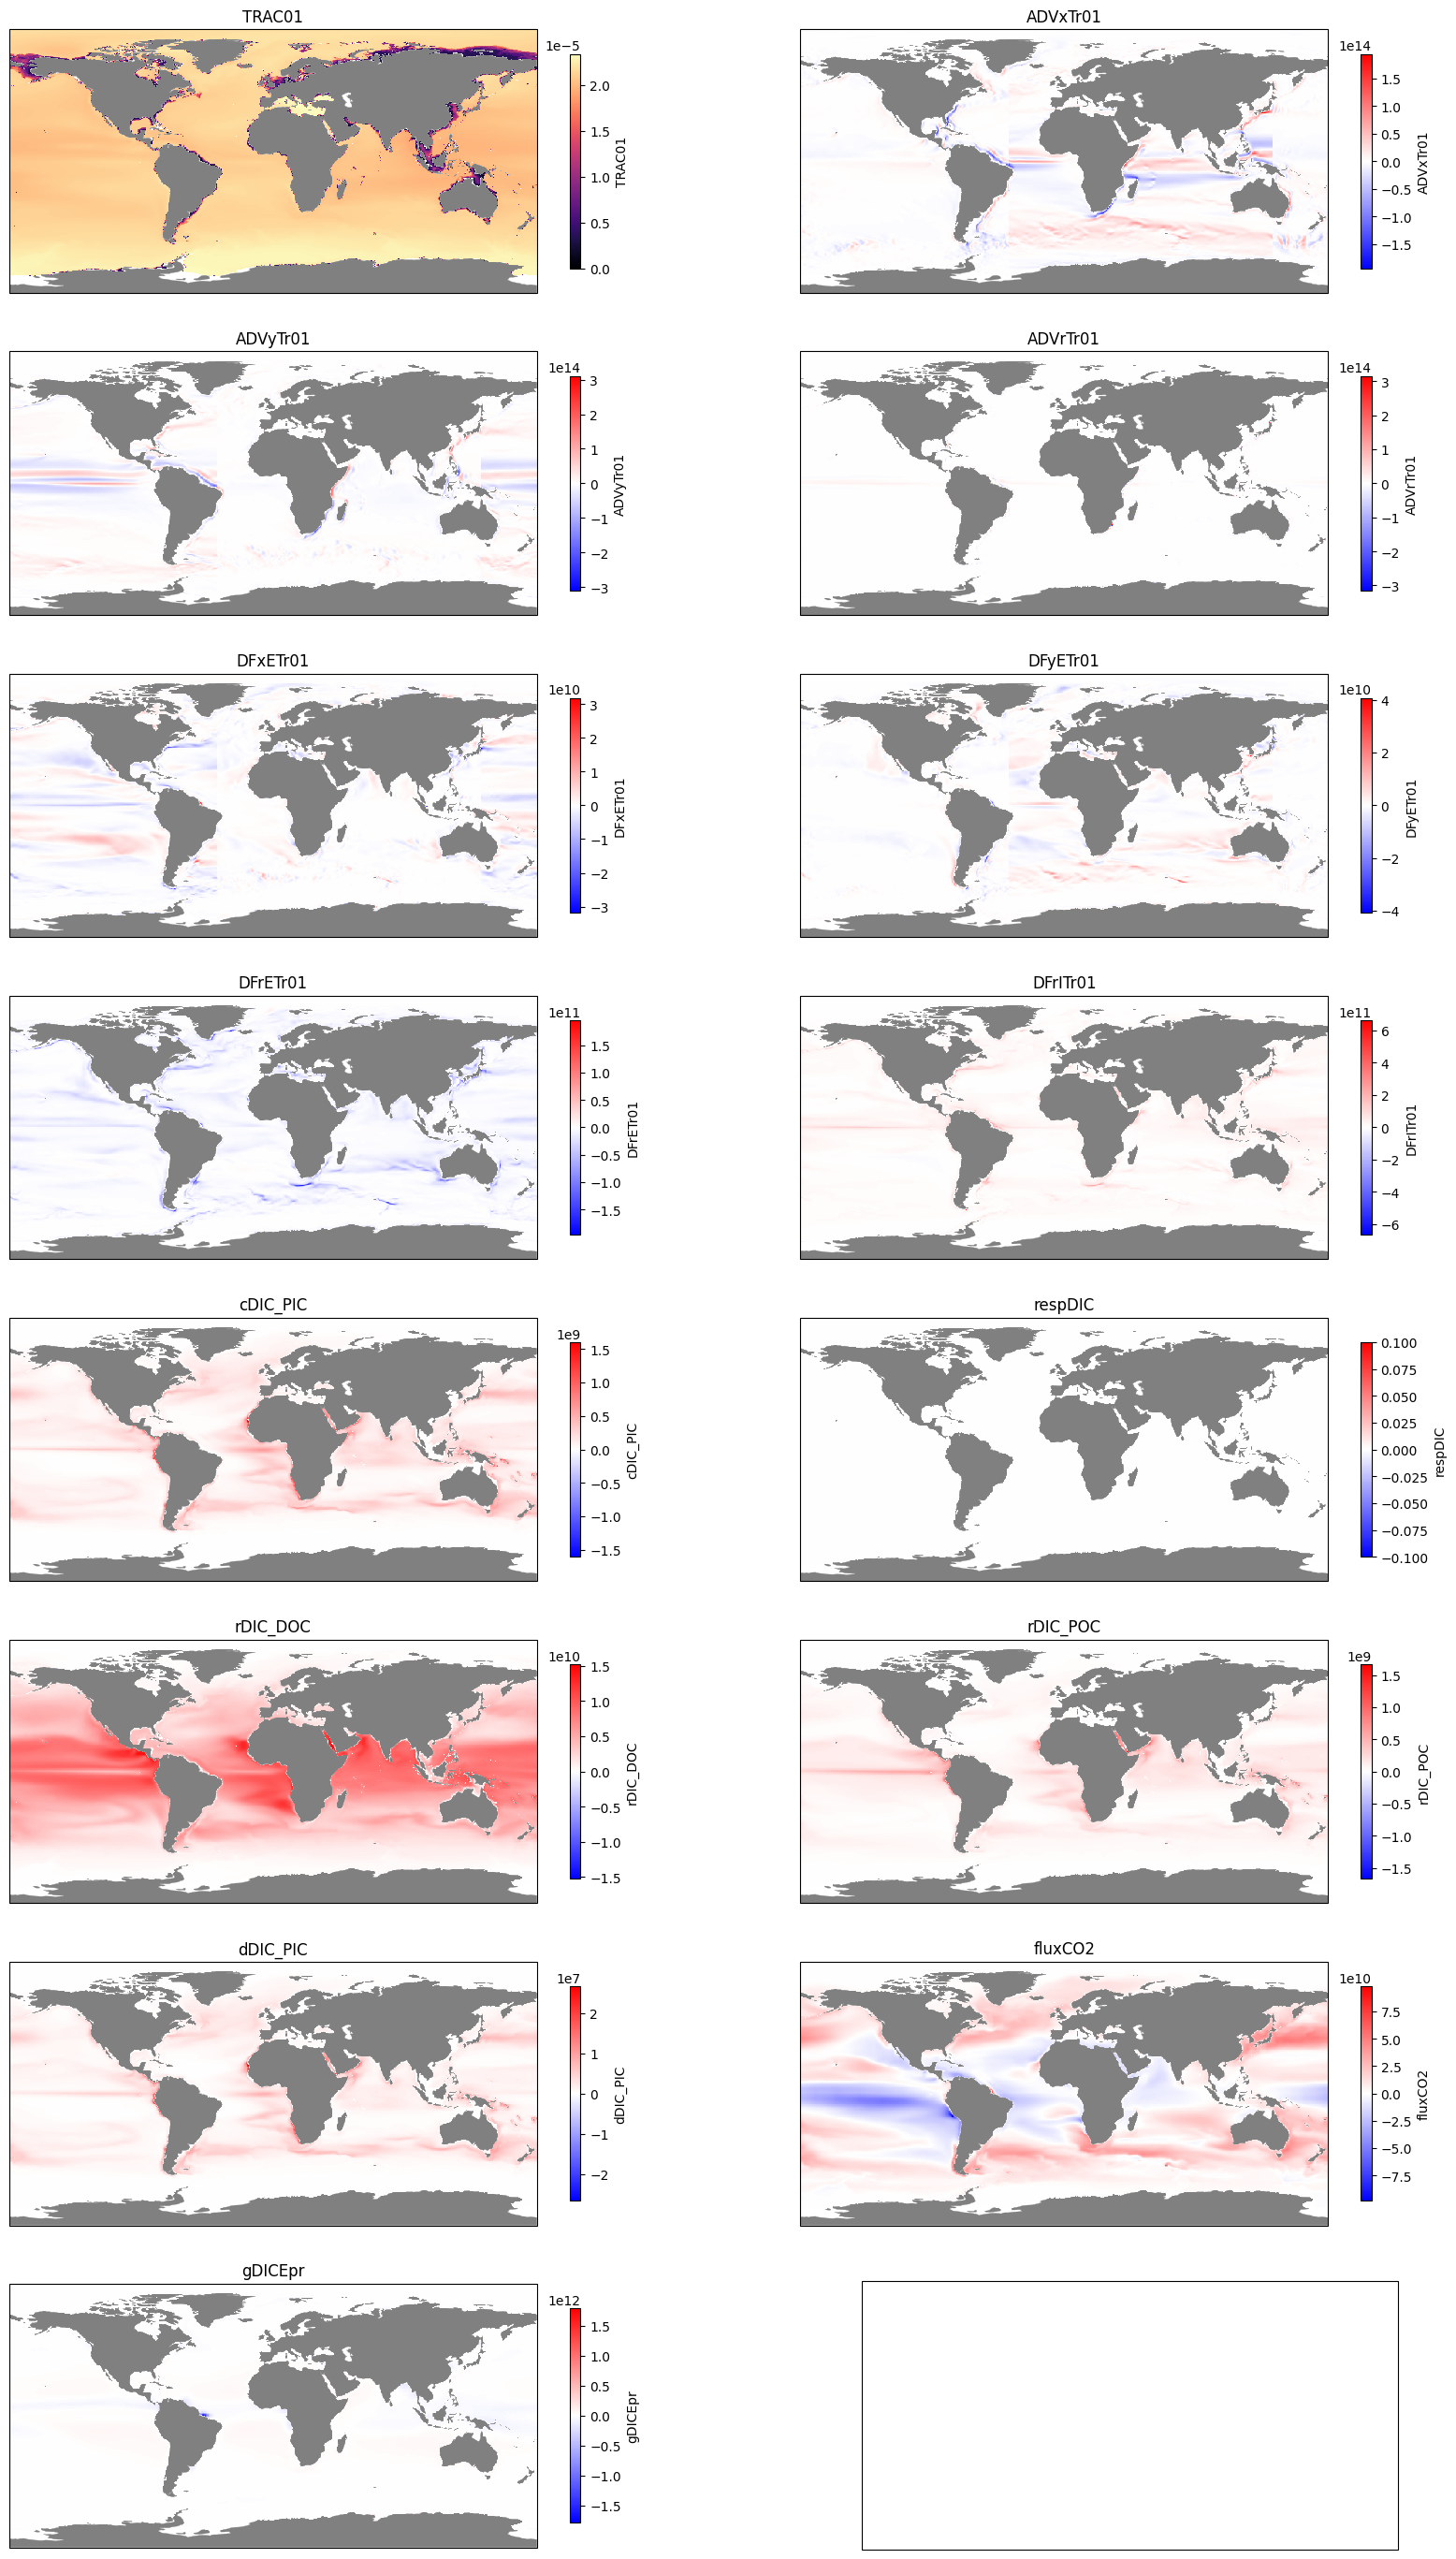

In [44]:
# pcolormesh for first iteration data
fig, axes = plt.subplots(8, 2, figsize=(20, 35), subplot_kw={'projection': ccrs.PlateCarree()})  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# iterate using utils functions
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = variables_cart[var_idx]  # Color values for the current variable

    if var_name == "TRAC01": 
        vmax,vmin,cmap  = np.nanmax(variables_cart_final[0]), 0, "magma"
    else:
        vmax,vmin,cmap = None, None, "bwr"
        
    plot_pcolor(ax=ax, values=variables_cart_final[var_idx], lon=lon_cart, lat=lat_cart, var_name=var_name,vmin=vmin, vmax=vmax,cmap=cmap)

plt.savefig("first timestep.png", dpi=300, bbox_inches="tight")
plt.show()